# Deep Learning Final Term - Adversarial Robustness Toolbox Experiment
## Indra Imanuel - 20195118

In [1]:
#Importing the necessary libraries

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
from art.defences.preprocessor import SpatialSmoothing, FeatureSqueezing
from art.utils import to_categorical

In [2]:
#Load MNIST Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_test = x_test[0:100]
y_test = y_test[0:100]

In [3]:
#Creating & compiling the model
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']);

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
#Train the model
model.fit(x_train, y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 22us/sample - loss: 0.2944 - accuracy: 0.9142
Epoch 2/5
60000/60000 [==============================] - 1s 22us/sample - loss: 0.1410 - accuracy: 0.9581
Epoch 3/5
60000/60000 [==============================] - 1s 22us/sample - loss: 0.1069 - accuracy: 0.9677
Epoch 4/5
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0892 - accuracy: 0.9721
Epoch 5/5
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0724 - accuracy: 0.9777


In [5]:
#Evaluate the model on the test data
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 249us/sample - loss: 0.0120 - accuracy: 1.0000
Accuracy on test data: 100.00%


In [6]:
#Creating ART Keras classifier
classifier = KerasClassifier(model=model, clip_values=(0, 1))

In [7]:
#See the prediction result (without any attack) using the classifier
predict_vanilla = classifier.predict(x_test)
label_vanilla = np.argmax(predict_vanilla, axis=1)[0]
confidence_vanilla = predict_vanilla[:, label_vanilla][0]

print("The image was: ", y_test[0], ", the prediction is: ", label_vanilla, ", the confidence {0:.2f}".format(confidence_vanilla))

The image was:  7 , the prediction is:  7 , the confidence 1.00


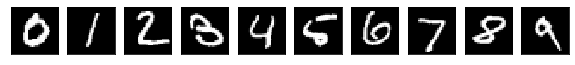

In [8]:
#MNIST Images before the adversarial attack
n = 10  # how many digits we will display
plt.figure(figsize=(10,2))
for i in range(n):
    idx = np.where(y_test == i)[0][0]
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Testing the attack mechanism of ART

In [9]:
#Doing the Fast Gradient Sign Method Attack <FGSM> (Untargeted Attack)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)

In [10]:
#Generate adversarial test data
x_test_adv1 = attack_fgsm.generate(x_test)

In [11]:
#Evaluate accuray on the adversarial image
loss_test, accuracy_test = model.evaluate(x_test_adv1, y_test)
perturbation = np.mean(np.abs((x_test_adv1 - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

100/100 [==============================] - 0s 30us/sample - loss: 16.7439 - accuracy: 0.0000e+00
Accuracy on adversarial test data: 0.00%
Average perturbation: 0.18


In [12]:
#See the prediction result of the classifier on the attacked image (FGSM)
predict_adv1 = classifier.predict(x_test_adv1)
label_adv1 = np.argmax(predict_adv1, axis=1)[0]
confidence_adv1 = predict_adv1[:, label_adv1][0]

print("The image was: ", y_test[0], ", the prediction is: ", label_adv1, ", the confidence {0:.2f}".format(confidence_adv1))

The image was:  7 , the prediction is:  3 , the confidence 0.70


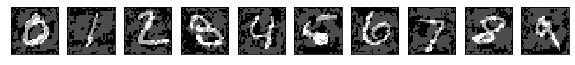

In [13]:
#MNIST Images after the adversarial attack (FGSM)
n = 10  # how many digits we will display
plt.figure(figsize=(10,2))
for i in range(n):
    idx = np.where(y_test == i)[0][0]
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_adv1[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
#Doing the Projected Gradient Descent Attack <PGD> (Untargeted)
attack_PGD = ProjectedGradientDescent(classifier, targeted=False, max_iter=10, eps_step=1, eps=5)

In [15]:
#Generate the adversarial sample
x_test_adv2 = attack_PGD.generate(x_test)

In [16]:
#Evaluate accuray on the adversarial image
loss_test, accuracy_test = model.evaluate(x_test_adv2, y_test)
perturbation = np.mean(np.abs((x_test_adv2 - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

100/100 [==============================] - 0s 30us/sample - loss: 182.7729 - accuracy: 0.0000e+00
Accuracy on adversarial test data: 0.00%
Average perturbation: 0.53


In [17]:
#See the prediction result of the classifier on the attacked image (PGD)
predict_adv2 = classifier.predict(x_test_adv2)
label_adv2 = np.argmax(predict_adv2, axis=1)[0]
confidence_adv2 = predict_adv2[:, label_adv2][0]

print("The image was: ", y_test[0], ", the prediction is: ", label_adv2, ", the confidence {0:.2f}".format(confidence_adv2))

The image was:  7 , the prediction is:  5 , the confidence 1.00


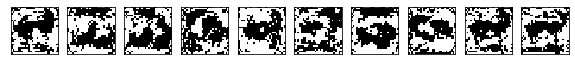

In [18]:
#MNIST Images after the adversarial attack (PGD)
n = 10  # how many digits we will display
plt.figure(figsize=(10,2))
for i in range(n):
    idx = np.where(y_test == i)[0][0]
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_adv2[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Testing the defense mechanism of ART

In [19]:
#Defense against FGSM by Spatial Smoothing
defense_ss = SpatialSmoothing(window_size=3)
x_test_adv_def1, _ = defense_ss(np.expand_dims(x_test_adv1, axis=0))

In [20]:
#Evaluate accuray on the defended adversarial image
loss_test, accuracy_test = model.evaluate(np.squeeze(x_test_adv_def1, axis=0), y_test)
perturbation = np.mean(np.abs((x_test_adv_def1 - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

100/100 [==============================] - 0s 35us/sample - loss: 10.0942 - accuracy: 0.0300
Accuracy on adversarial test data: 3.00%
Average perturbation: 0.23


In [21]:
#See the prediction result of the classifier on the attacked image (FGSM) with Spatial Smoothing Defense
pred_adv_def1 = classifier.predict(np.squeeze(x_test_adv_def1,axis=0))
label_adv_def1 = np.argmax(pred_adv_def1, axis=1)[0]
confidence_adv_def1 = pred_adv_def1[:, label_adv_def1][0]

print('Prediction of original sample:', y_test[0])
print('Prediction of adversarial sample:', label_adv_def1, 
      '- confidence {0:.2f}'.format(confidence_adv_def1))

Prediction of original sample: 7
Prediction of adversarial sample: 3 - confidence 0.64


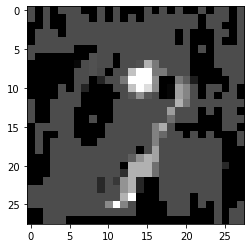

In [22]:
#Plot the adversarial image (FGSM) with spatial smoothing defense
plt.imshow(x_test_adv_def1[0][0].reshape(28, 28))

In [23]:
#Defense againts PGD by feature squeezing
defense_fs = FeatureSqueezing(clip_values=(3,5))
x_test_adv_def2, _ = defense_fs(x_test_adv2)

In [24]:
#Evaluate accuray on the defended adversarial image
loss_test, accuracy_test = model.evaluate(x_test_adv_def2, y_test)
perturbation = np.mean(np.abs((x_test_adv_def2 - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

100/100 [==============================] - 0s 40us/sample - loss: 181.9824 - accuracy: 0.0000e+00
Accuracy on adversarial test data: 0.00%
Average perturbation: 0.53


In [25]:
pred_adv_def2 = classifier.predict(x_test_adv_def2)
label_adv_def2 = np.argmax(pred_adv_def2, axis=1)[0]
confidence_adv_def2 = pred_adv_def2[:, label_adv_def2][0]

print('Prediction of original sample:', y_test[0])
print('Prediction of adversarial sample:', label_adv_def2, 
      '- confidence {0:.2f}'.format(confidence_adv_def2))

Prediction of original sample: 7
Prediction of adversarial sample: 5 - confidence 1.00


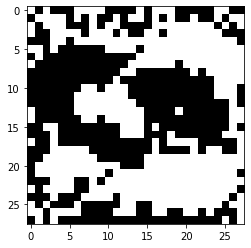

In [26]:
#Plot the adversarial image (PGD) with Feature Squeezing defense
plt.imshow(x_test_adv_def2[0].reshape(28, 28))

### Calculating L0, L2, L-inf

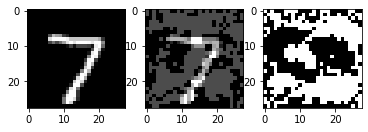

In [27]:
#Select the image that wants to be compared
original_image = x_test[0]
fgsm_image = x_test_adv1[0]
pgd_image = x_test_adv2[0]

#plot them
f, axarr = plt.subplots(1,3)
axarr[0].imshow(original_image)
axarr[1].imshow(fgsm_image)
axarr[2].imshow(pgd_image)

In [28]:
#Original Image & FGSM
ori_fgsm = original_image-fgsm_image

L0_dist1 = (sum(sum(ori_fgsm != 0))) / np.size(ori_fgsm)
L2_dist1 = np.linalg.norm(ori_fgsm)
L_inf_dist1 = np.linalg.norm(ori_fgsm, np.inf)

print("L0 Original & FGSM    : {:4.2f}%".format(L0_dist1 * 100))
print("L2 Original & FGSM    : ", L2_dist1)
print("L inf Original & FGSM : ", L_inf_dist1)
print("")
#Original Image & PGD
ori_pgd = original_image-pgd_image

L0_dist2 = (sum(sum(ori_pgd != 0))) / np.size(ori_pgd)
L2_dist2 = np.linalg.norm(ori_pgd)
L_inf_dist2 = np.linalg.norm(ori_pgd, np.inf)

print("L0 Original & PGD    : {:4.2f}%".format(L0_dist2 * 100))
print("L2 Original & PGD    : ", L2_dist2)
print("L inf Original & PGD : ", L_inf_dist2)

L0 Original & FGSM    : 64.03%
L2 Original & FGSM    :  6.531633532084609
L inf Original & FGSM :  7.200000286102295

L0 Original & PGD    : 61.22%
L2 Original & PGD    :  20.35036554786092
L inf Original & PGD :  24.807843137254903


### Targeted Attack

In [29]:
#Targeted attack
attack_PGD_targeted = ProjectedGradientDescent(classifier, targeted=True, max_iter=40, eps_step=1, eps=5)

In [30]:
#Define the target class
y_target = [5]
y_target_onehot = to_categorical(y_target, 10)
print(y_target_onehot)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [31]:
#Preprocess the data
x_test_targeted = np.expand_dims(x_test[0], axis=0)
print(x_test_targeted.shape)

(1, 28, 28)


In [32]:
#Generate the adversarial sample:
x_test_adv_targeted = attack_PGD_targeted.generate(x_test_targeted, y=y_target_onehot)

In [33]:
#See the prediction result of the classifier on the attacked image (PGD targeted)
predict_adv_targeted = classifier.predict(x_test_adv_targeted)
label_adv_targeted = np.argmax(predict_adv_targeted, axis=1)[0]
confidence_adv_targeted = predict_adv_targeted[:, label_adv_targeted][0]

print("The image was: ", y_test[0], ", the prediction is: ", label_adv_targeted, ", the confidence {0:.2f}".format(confidence_adv_targeted))

The image was:  7 , the prediction is:  5 , the confidence 1.00


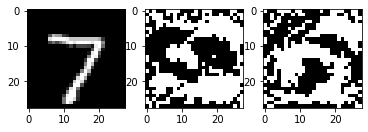

In [34]:
#Plot the images (original, untargeted attack, targeted attack)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(original_image)
axarr[1].imshow(pgd_image)
axarr[2].imshow(x_test_adv_targeted.reshape(28, 28))

In [35]:
#Calculate L2 distance
#Untargeted
L2_dist_untargeted = np.linalg.norm(ori_pgd)
print("L2 Original & PGD Untargeted   : ", L2_dist_untargeted)

#Targeted
ori_pgd_targeted = original_image - x_test_adv_targeted[0]
L2_dist_targeted = np.linalg.norm(ori_pgd_targeted)
print("L2 Original & PGD Targeted   : ", L2_dist_targeted)

L2 Original & PGD Untargeted   :  20.35036554786092
L2 Original & PGD Targeted   :  20.671665875986566
